#### Projeto para investigar as consequências e como lidar com *datasets* desbalanceados em projetos de Ciência de Dados

#### Como Lidar com Dados Desbalanceados

Saber como lidar com dados desbalanceados pode fazer toda a diferença no no seu projeto de *Data Science* e no desempenho do seu modelo de *Machine Learning*.

Você provavelmente já se deparou com a situação de encontrar um *dataset* onde havia um nítido desequilíbrio entre as amostras de suas diferentes classes.

Alguns exemplos de situações onde o desbalanceamento é quase certo são problemas de detecção de fraude e diagnóstico médicos - é intuitivo pensar que existem mais transações lícitas que criminosas, ou que o conjunto de pessoas diagnosticadas com câncer é bem menor que o conjunto de pessoas sem a doença.

Ignorar esse fato e treinar um algoritmo em cima do conjunto de dados original, pulando uma etapa intermediária de balanceamento dos dados, pode ter impactos diretos no seu projeto de *Data Science*.

#### Consequências dos Dados Desbalanceados

Se você está construindo um modelo de *machine learning* para classificação, por exemplo, a consequência desse desequilíbrio é que o modelo terá uma tendência a dar muitos "alarmes falsos".

Ou seja, na prática ele irá responder muito bem entradas para as classes majoritárias, mas terá um desempenho inferior para as minoriárias.

No exemplo de detecção de fraude com cartões de crédito (onde o número de transações financeiras normais é bem maior que o número de transações fraudulentas), um classificador tenderá a apresentar muitos falsos negativos - uma situação indesejável para um banco, obviamente.

Em um *trade-off*, seria preferível "errar para mais" e ter uma quantidade maior de falsos positivos. Aliás, aposto que você já teve seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito, não é mesmo?!

Teoricamente, um *dataset* que possua qualquer classe com mais de 50% das entradas já é considerado desbalanceado. No entanto, há situações extremas onde você vai encontrar proporções maiores que 99:1.

Existem várias abordagens para lidar com dados desbalanceados, cada uma com seus prós e contras. Neste artigo, irei mostrar alguns dos métodos mais populares para você incluir desde já no seu arsenal.

#### Vantagens e Desvantagens de cada Técnica

[O Teorema *No Free Lunch*](https://www.kdnuggets.com/2019/09/no-free-lunch-data-science.html) diz que não existem um perfeito e único, apenas com vantagens. Cada escolha, uma renúncia, isso é *Data Science*. Quando você opta por uma abordagem, tem que estar ciente das limitações e implicações nos seus resultados -  e transmitir isso para os *stakeholders*.

- *Over-sampling* replica os dados já existentes, aumentando o número de instâncias das classes minoritárias. A vantagem é que nenhuma informação é descartada, porém o custo computacional será elevado e você irá deteriorar a performance do algoritmo para as classes minoritárias.

- Já o *Under-sampling* vai extrair um subconjunto aleatório da classe majoritária, preservando as características da classe minoritária, sendo ideal para situações onde você tem grandes volumes de dados. Apesar de reduzir o tempo computacional e de armazenamento, esta técnica descarta informações da classe majoritária, o que pode levar a uma performance inferior nas predições dela.

Além dessas duas técnicas de *sampling*, existem também os *advanced sampling methods* como SMOTE e ADASYN, onde instâncias são adicionadas ou removidas adaptativamente. 

Caso tenha curiosidade em conhecer mais e se aprofundar no assunto, [recomendo este artigo científico](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1806&context=infopapers).

In [5]:
# Importar bibliotecas necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

# Suprimir os warnings
from warnings import simplefilter
simplefilter(action = 'ignore', category = FutureWarning)

#### Pré-Processamento dos Dados

In [6]:
# Ler e carregar a base de dados
dados = 'pima_data.csv'
pacientes_df = pd.read_csv(dados, header = 0) # Criar dataframe

# Examinar a base de dados
linhas, colunas = pacientes_df.shape # Extrair tamanho da base de dados
print('A base de dados carregada possui {} linhas e {} colunas.'.format(linhas, colunas)) # Apresentar informação ao usuário
# display(pacientes_df) # Apresenta primeiras e últimas linhas da base de dados
pacientes_df.head(10) # Visualizar as 10 primeiras linhas da base de dados
# pacientes_df.tail(10) # Visualizar as 10 últimas linhas da base de dados

A base de dados carregada possui 768 linhas e 10 colunas.


,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3780,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True
5,5,116,74,0,0,25.6,0.201,30,0.0000,False
6,3,78,50,32,88,31.0,0.248,26,1.2608,True
7,10,115,0,0,0,35.3,0.134,29,0.0000,False
8,2,197,70,45,543,30.5,0.158,53,1.7730,True
9,8,125,96,0,0,0.0,0.232,54,0.0000,True


In [7]:
# Definir as classes do problema de negócio
diabetes_map = {True : 1, False : 0} # Mapear rótulos
pacientes_df['diabetes'] = pacientes_df['diabetes'].map(diabetes_map) # Aplicar o mapeamento a base de dados
pacientes_df.head(5) # Verificar as 5 primeiras linhas da base de dados para comfirmar o correto mapeamento das classes alvo

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3780,1
1,1,85,66,29,0,26.6,0.351,31,1.1426,0
2,8,183,64,0,0,23.3,0.672,32,0.0000,1
3,1,89,66,23,94,28.1,0.167,21,0.9062,0
4,0,137,40,35,168,43.1,2.288,33,1.3790,1


In [8]:
# Verificar a distribuição dos dados na base de dados
# O ideal é que a distribuição seja igual entre as classes
n_true = len(pacientes_df.loc[pacientes_df['diabetes'] == 1]) # Quantidade de rótulos da classe 1
n_false = len(pacientes_df.loc[pacientes_df['diabetes'] == 0]) # Quantidade de rótulos da classe 0
print('Número de Casos Verdadeiros (Classe 1): {} ({:.2%})'.format(n_true, (n_true/ (n_true + n_false))))
print('Número de Casos Falsos (Classe 0)     : {} ({:.2%})'.format(n_false, (n_false/ (n_true + n_false))))
print("Sendo assim, nossa base de dados está desbalanceada.\n")

Número de Casos Verdadeiros (Classe 1): 268 (34.90%)
Número de Casos Falsos (Classe 0)     : 500 (65.10%)
Sendo assim, nossa base de dados está desbalanceada.



Para se ter um ideia real das consequências dessa situação, irei construir dois modelos de Regressão Logística.

No nosso primeiro modelo, separei as variáveis `X` e `Y` normalmente e dividi entre conjuntos de treino e teste, como é praxe em *machine learning*. Sem maiores ajustes, treinei o modelo usando o método `fit(X_treino, y_treino)` e fiz a previsão de valores em cima do conjunto de teste (`X_teste`).

Na sequência, plotei a matriz de confusão e o relatório de classificação.

#### Dividir Dados para Treinamento e Validação

In [9]:
# Separar base de dados em 70% para dados de treino e 30% para dados de teste
from sklearn.model_selection import train_test_split # Importar módulo

# Seleção de variáveis preditoras (Inputs - Feature Selection)
atributos = ['num_preg', 'glucose_conc', 'diastolic_bp', 'thickness', 'insulin', 'bmi', 'diab_pred', 'age']

# Variável a ser predita (Output - Target)
target = ['diabetes']

# Criar variáveis de entrada (input) e saída (output)
X = pacientes_df[atributos].values
Y = pacientes_df[target].values

split_test_size = 0.30 # Definir a taxa percentual de dados reservado para etapa de teste

# Separar base de dados em dados de treino e dados de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = split_test_size, stratify = Y,
                                                        shuffle = True, random_state = 42)

# Verificar se a base de dados foi separada corretamente
print('{:0.2%} dos dados para treinamento.'.format((len(X_treino)/len(pacientes_df.index))))
print('{:0.2%} nos dados para validação.'.format((len(X_teste)/len(pacientes_df.index))))

69.92% dos dados para treinamento.
30.08% nos dados para validação.


#### Descobrir e Tratar Valores Missing (Faltantes) Ocultos na Base de Dados

In [10]:
# Valores que não representam a realidade corretamente, necessário analisar e conhecer bem os significados dos atributos
print("# Linhas no dataframe: {0}.".format(len(pacientes_df)))
print("# Linhas missing glucose_conc: {0}.".format(len(pacientes_df.loc[pacientes_df['glucose_conc'] == 0])))
print("# Linhas missing diastolic_bp: {0}.".format(len(pacientes_df.loc[pacientes_df['diastolic_bp'] == 0])))
print("# Linhas missing thickness: {0}.".format(len(pacientes_df.loc[pacientes_df['thickness'] == 0])))
print("# Linhas missing insulin: {0}.".format(len(pacientes_df.loc[pacientes_df['insulin'] == 0])))
print("# Linhas missing bmi: {0}.".format(len(pacientes_df.loc[pacientes_df['bmi'] == 0])))
print("# Linhas missing age: {0}.".format(len(pacientes_df.loc[pacientes_df['age'] == 0])))

from sklearn.impute import SimpleImputer # Importar módulo
# Substituir os valores iguais a zero, pela média dos dados em cada coluna
zero_imputer = SimpleImputer(missing_values = 0, strategy = "mean") # Solução simples para tratar os valores faltantes

# Substituindo os valores iguais a zero, pela média dos dados
X_treino = zero_imputer.fit_transform(X_treino) # Realizar imputação nos dados de treino
X_teste = zero_imputer.fit_transform(X_teste) # Realizar imputação nos dados de teste

# Linhas no dataframe: 768.
# Linhas missing glucose_conc: 5.
# Linhas missing diastolic_bp: 35.
# Linhas missing thickness: 227.
# Linhas missing insulin: 374.
# Linhas missing bmi: 11.
# Linhas missing age: 0.


#### Modelo via Regressão Logística

In [11]:
from sklearn.linear_model import LogisticRegression # Importar classificador Logistic Regression
from sklearn.preprocessing import MinMaxScaler # Importar método para escalonar dados dentro de um determinado intervalo

scaler = MinMaxScaler() # Instanciar método para pré-processar os dados
X_norm = scaler.fit_transform(X) # Aplicar transformação nos dados

# Separar base de dados em dados de treino e dados de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X_norm, Y, test_size = split_test_size, random_state = 42)

modelo_v1 = LogisticRegression(C = 0.7, random_state = 42, max_iter = 1000) # Criar o modelo
modelo_v1.fit(X_treino, Y_treino.ravel()) # Treinar o modelo
print('Modelo Treinado.')

Modelo Treinado.


In [12]:
# Verificar a Acurácia no Modelo nos Dados de Teste
lr_predict_test = modelo_v1.predict(X_teste) # Predizer saídas usando os dados de validação
print("Precisão nos dados de teste (Accuracy): {0:.2%}".format(accuracy_score(Y_teste, lr_predict_test)))

Precisão nos dados de teste (Accuracy): 76.19%


In [13]:
# Verificar a AUC (Area Under Curve - Área Sob a Curva)
print("AUC nos dados de teste: {:.2%}\n".format(roc_auc_score(Y_teste, lr_predict_test)))

AUC nos dados de teste: 71.21%



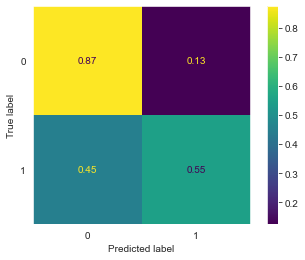

In [14]:
# Criar uma Confusion Matrix (Matriz de Confusão)
cm = confusion_matrix(Y_teste, lr_predict_test, labels = modelo_v1.classes_, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = modelo_v1.classes_)
disp.plot(), plt.show();

In [15]:
print("Classification Report") # Relatório sobre as classificações realizadas na base de teste
print(classification_report(Y_teste, lr_predict_test, labels = modelo_v1.classes_, digits = 4)) # Apresentar ao usuário

Classification Report
              precision    recall  f1-score   support

           0     0.7857    0.8742    0.8276       151
           1     0.6984    0.5500    0.6154        80

    accuracy                         0.7619       231
   macro avg     0.7421    0.7121    0.7215       231
weighted avg     0.7555    0.7619    0.7541       231



Conseguimos uma acurácia de 76,19% no nosso modelo de *machine learning*. **Você considera esse um bom resultado?**

Bem,  acurácia global foi alta, mas o que dizer daquele fator que mais importava para nós, a **capacidade de detectar pessoas com diabetes?**

Aí é outra história... por causa do desbalanceamento de dados, o modelo foi capaz de classificar bem as instâncias onde `pacientes_df.diabetes == 0` (pessoas sadias), mas acertou somente 55% dos casos em que `pacientes_df.diabetes == 1` (pessoas infermas).

Vamos ver agora qual seria o resultado caso tivessemos usado a técnica ***Under-sampling***. Para facilitar esse pré-processamento, irei usar a biblioteca `imblearn` com sua classe `imblearn.under_sampling.RandomUnderSampler` e chamar o método `fit_resample(X_treino, y_treino)`.

Note como eu estou usando o *under-sampling* em cima do conjunto de treino, e não de todos os dados. Isso é muito importante para não desconfigurarmos a característica de teste original do *dataset*.

In [50]:
# Usar Técnica Under-sampling
rus = RandomUnderSampler(sampling_strategy = 'auto', random_state = 42)
X_rus, Y_rus = rus.fit_resample(X_treino, Y_treino) # Balancear a base de dados

# Conferir o Balanceamento das Classes
print(pd.DataFrame(Y_res).value_counts())

# Usar Técnica Over-sampling
ros = RandomOverSampler(sampling_strategy = 'auto', random_state = 42)
X_ros, Y_ros = ros.fit_resample(X_treino, Y_treino) # Balancear a base de dados

# Conferir o Balanceamento das Classes
print(pd.DataFrame(Y_ros).value_counts())

0    188
1    188
dtype: int64
0    349
1    349
dtype: int64


O novo conjunto está corretamente balanceado agora, eliminando boa parte do problema que tínhamos inicialmente. Novamente, irei instanciar um novo modelo de Regressão Logística e treiná-lo nesses dados balanceados. Vamos conferir as métricas de avaliação usadas e ver o que mudou.

In [43]:
modelo_v2 = LogisticRegression(C = 0.7, random_state = 42, max_iter = 1000) # Criar o modelo
modelo_v2.fit(X_rus, Y_rus.ravel()) # Treinar o modelo
print('Modelo Treinado.')

Modelo Treinado.


In [44]:
# Verificar a Acurácia no Modelo nos Dados de Teste
lr_predict_test = modelo_v2.predict(X_teste) # Predizer saídas usando os dados de validação
print("Precisão nos dados de teste (Accuracy): {0:.2%}".format(accuracy_score(Y_teste, lr_predict_test)))

Precisão nos dados de teste (Accuracy): 68.40%


In [45]:
# Verificar a AUC (Area Under Curve - Área Sob a Curva)
print("AUC nos dados de teste: {:.2%}\n".format(roc_auc_score(Y_teste, lr_predict_test)))

AUC nos dados de teste: 67.60%



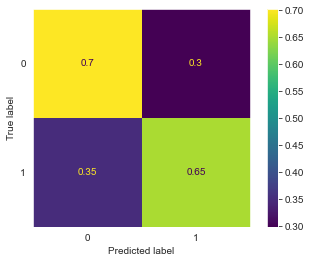

In [46]:
# Criar uma Confusion Matrix (Matriz de Confusão)
cm = confusion_matrix(Y_teste, lr_predict_test, labels = modelo_v2.classes_, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = modelo_v2.classes_)
disp.plot(), plt.show();

In [47]:
print("Classification Report") # Relatório sobre as classificações realizadas na base de teste
print(classification_report(Y_teste, lr_predict_test, labels = modelo_v2.classes_, digits = 4)) # Apresentar ao usuário

Classification Report
              precision    recall  f1-score   support

           0     0.7910    0.7020    0.7439       151
           1     0.5361    0.6500    0.5876        80

    accuracy                         0.6840       231
   macro avg     0.6636    0.6760    0.6657       231
weighted avg     0.7027    0.6840    0.6897       231



Repare que apesar da acurácia global ter diminuído de 76,19% para 70,56%, tivemos um aumento significativo na capacidade do modelo em detectar pacientes diabéticos (percetual de acertos subiu de 55% para 65%. Apenas pelo fato de balancearmos os dados, melhoramos diversos parâmetros como `recall` e quase não alteramos área sob a curva (AUC), que são métricas extremamente importantes para o problema que estamos lidando.

O valor do AUC varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe. Quanto maior o AUC, melhor.

Um modelo cujas previsões estão 100% erradas tem uma AUC de 0, enquanto um modelo cujas previsões são 100% corretas tem uma AUC de 1. Cada modelo apresentará um valor de AUC, o que irá te auxiliar na escolha do melhor

#### Balanceamento de Dados no Mundo Real

São diversos os motivos que permitem que os dados sejam desbalanceados. Pode ser que o cientista de dados não conseguiu coletar igualmente dados de cada classe, ou pode ser que a amostra realmente reflita a população.

Independente dos motivos, o não tratamente desse desbalanceamento afeta negativamente o desempenho do modelo, refletindo na qualidade global do seu projeto de *Data Science*.

Não existe um método universal e ótimo. Existem técnicas que evoluem constantemente, e cabe a você (cientista de dados) identificar os prós e contras de cada uma e experimentar as mais diversas abordagens (experimentação).

Por isso, recomendo não acompanhar apenas sites como o Kaggle, mas também acompanhar *papers* e trabalhos acadêmicos que tragam pesquisas recentes nessa área em constante evolução.